In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", False)
from sklearn.metrics import mean_absolute_percentage_error
from datetime import date, timedelta, datetime

In [2]:
df = pd.read_csv('../raw_data/data_preparation.csv', index_col=[0])


In [3]:
# test

In [4]:
Date_debut_test = '2022-01-01'    # <= Inférieur ou Egal
Nombre_jours_test = 14

Date_debut_test_time_ = pd.to_datetime(Date_debut_test)
Date_fin_test_time_ =  Date_debut_test_time_ + timedelta(Nombre_jours_test)
Date_fin_test = str(Date_fin_test_time_)[0:10]
Date_fin_test

'2022-01-15'

In [5]:
type(Date_debut_test)

str

In [6]:
df_train = df[ (df["Date"] < Date_debut_test)]
df_test = df[ (df["Date"] >= Date_debut_test) & (df["Date"] < Date_fin_test)]

In [7]:
print(df_train.shape)
print(df_test.shape)

(3255, 85)
(14, 85)


In [8]:
df_train

Date  Code INSEE région  ...    t - 29    t - 30
32    2013-02-02               4464  ...  286799.0  285526.0
33    2013-02-03               4464  ...  267848.0  286799.0
34    2013-02-04               4464  ...  257432.0  267848.0
35    2013-02-05               4464  ...  270102.0  257432.0
36    2013-02-06               4464  ...  280984.0  270102.0
...          ...                ...  ...       ...       ...
3282  2021-12-27               4464  ...  269774.0  262056.0
3283  2021-12-28               4464  ...  291928.0  269774.0
3284  2021-12-29               4464  ...  305772.0  291928.0
3285  2021-12-30               4464  ...  301568.0  305772.0
3286  2021-12-31               4464  ...  292188.0  301568.0

[3255 rows x 85 columns]

#  Pipeline

In [9]:
preproc_MinMaxScaler = make_pipeline(MinMaxScaler())
preproc_StandardScaler = make_pipeline(StandardScaler()) 
preproc_RobustScaler = make_pipeline( RobustScaler())

In [10]:
min_max = ['t - 1', 't - 2', 't - 3', 't - 4', 't - 5', 't - 6', 't - 7', 't - 8', 't - 9',
       't - 10', 't - 11', 't - 12', 't - 13', 't - 14', 't - 15', 't - 16',
       't - 17', 't - 18', 't - 19', 't - 20', 't - 21', 't - 22', 't - 23',
       't - 24', 't - 25', 't - 26', 't - 27', 't - 28', 't - 29', 't - 30']
stand = ['T2MDEW','T2M_RANGE']
robus = ['T2M', 'T2MWET', 'TS', 'T2M_MAX', 'T2M_MIN','QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 
         'WS10M', 'WS50M']

In [11]:
preproc = make_column_transformer(
    (preproc_MinMaxScaler, min_max),
    (preproc_StandardScaler, stand),
    (preproc_RobustScaler, robus),
    remainder="passthrough")

preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['t - 1', 't - 2', 't - 3', 't - 4', 't - 5',
                                  't - 6', 't - 7', 't - 8', 't - 9', 't - 10',
                                  't - 11', 't - 12', 't - 13', 't - 14',
                                  't - 15', 't - 16', 't - 17', 't - 18',
                                  't - 19', 't - 20', 't - 21', 't - 22',
                                  't - 23', 't - 24', 't - 25', 't - 26',
                                  't - 27', 't - 28', 't - 29', 't - 30']),
                                ('pipeline-2',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['T2MDEW', 'T2M_RANGE']),

## Pilpeline XGboost

In [12]:
model_xgb = XGBRegressor(colsample_bytree = 1, 
                         gamma= 0.1, 
                         max_depth= 16, 
                         min_child_weight= 6, 
                         n_estimators= 100,
                         learning_rate=0.1)

In [13]:
pipeline_xgb_final = make_pipeline(preproc,model_xgb)
pipeline_xgb_final

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['t - 1', 't - 2', 't - 3',
                                                   't - 4', 't - 5', 't - 6',
                                                   't - 7', 't - 8', 't - 9',
                                                   't - 10', 't - 11', 't - 12',
                                                   't - 13', 't - 14', 't - 15',
                                                   't - 16', 't - 17', 't - 18',
                                                   't - 19', 't - 20', 't - 21',
                                                   't - 22', 't - 23', 't - 24',
                              

# Création data frame

In [14]:
X_train = df_train.drop(columns=['Date', 'Code INSEE région', 'Consommation (MW)', 'Thermique (MW)',
       'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)',
       'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)',
       'Stockage batterie', 'Déstockage batterie', 'Eolien terrestre',
       'Eolien offshore', 'TCO Thermique (%)', 'TCH Thermique (%)',
       'TCO Nucléaire (%)', 'TCH Nucléaire (%)', 'TCO Eolien (%)',
       'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'Column 30','YEAR', 'MONTH', 'DAY', 'season', 'num_day'])

y_train = df_train['Consommation (MW)']

In [15]:
X_test = df_test.drop(columns=['Date', 'Code INSEE région', 'Consommation (MW)', 'Thermique (MW)',
       'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)',
       'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)',
       'Stockage batterie', 'Déstockage batterie', 'Eolien terrestre',
       'Eolien offshore', 'TCO Thermique (%)', 'TCH Thermique (%)',
       'TCO Nucléaire (%)', 'TCH Nucléaire (%)', 'TCO Eolien (%)',
       'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'Column 30','YEAR', 
        'MONTH', 'DAY', 'season', 'num_day',
       ])

y_test = df_test['Consommation (MW)']

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3255, 56)
(3255,)
(14, 56)
(14,)


In [17]:
X_test[['t - 26', 't - 27', 't - 28', 't - 29', 't - 30']]

t - 26    t - 27    t - 28    t - 29    t - 30
3287  300417.0  282151.0  288467.0  305131.0  292188.0
3288  299330.0  300417.0  282151.0  288467.0  305131.0
3289  292962.0  299330.0  300417.0  282151.0  288467.0
3290  303355.0  292962.0  299330.0  300417.0  282151.0
3291  312649.0  303355.0  292962.0  299330.0  300417.0
3292  296111.0  312649.0  303355.0  292962.0  299330.0
3293  291382.0  296111.0  312649.0  303355.0  292962.0
3294  304035.0  291382.0  296111.0  312649.0  303355.0
3295  301230.0  304035.0  291382.0  296111.0  312649.0
3296  291292.0  301230.0  304035.0  291382.0  296111.0
3297  297442.0  291292.0  301230.0  304035.0  291382.0
3298  296310.0  297442.0  291292.0  301230.0  304035.0
3299  279167.0  296310.0  297442.0  291292.0  301230.0
3300  278483.0  279167.0  296310.0  297442.0  291292.0

# Fit model

In [18]:
pipeline_xgb_final.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['t - 1', 't - 2', 't - 3',
                                                   't - 4', 't - 5', 't - 6',
                                                   't - 7', 't - 8', 't - 9',
                                                   't - 10', 't - 11', 't - 12',
                                                   't - 13', 't - 14', 't - 15',
                                                   't - 16', 't - 17', 't - 18',
                                                   't - 19', 't - 20', 't - 21',
                                                   't - 22', 't - 23', 't - 24',
                              

In [19]:
X_test.shape

(14, 56)

# Prédictions

In [20]:
predictions = []

X_test_i = pd.DataFrame([X_test.iloc[0,26:]])

X_test_0 = pd.DataFrame([X_test.iloc[0,:]])

y_i = pipeline_xgb_final.predict(X_test_0)

predictions.append(y_i[0])

In [21]:
for i in range (1,Nombre_jours_test):
    X_test_features = pd.DataFrame([X_test.iloc[i,:26]])

    
    X_test_i.iloc[0,1:] = X_test_i.iloc[0,:-1]
    X_test_i.iloc[0,0] = y_i[0]
    
    X_test_decal = pd.DataFrame(X_test_i)
    
 
    X_test_pred = pd.merge(left = X_test_features.reset_index(drop = True), right = X_test_decal.reset_index(drop = True),
                left_index = True, right_index = True)
    
    y_i= pipeline_xgb_final.predict(X_test_pred)
    

    predictions.append(y_i[0])

In [22]:
len(predictions)

14

In [23]:
X_train.shape

(3255, 56)

# Lecture prédictions

In [24]:
type(y_test)

pandas.core.series.Series

In [25]:
y_test_list = y_test.tolist()

In [26]:
y_test_list

[238154.0,
 244688.0,
 264457.0,
 270029.0,
 272530.0,
 295703.0,
 307289.0,
 286384.0,
 270763.0,
 286741.0,
 303781.0,
 311252.0,
 313535.0,
 311759.0]

In [27]:
MAPE = mean_absolute_percentage_error(y_test, predictions)
MAPE

0.020387443598371847

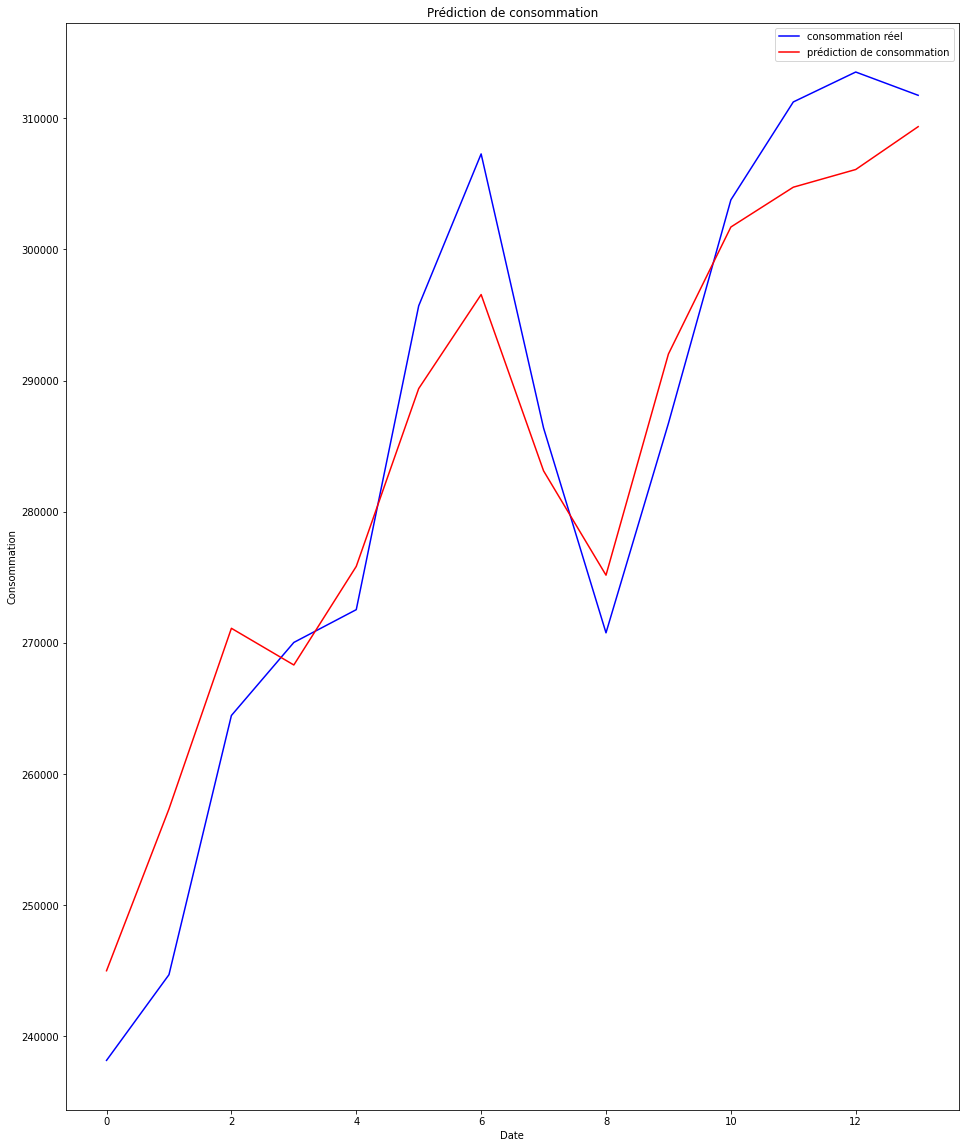

In [28]:
plt.figure(figsize=(16,20))#figsize=(10,6)
plt.plot(y_test_list, color='blue', label='consommation réel')
plt.plot(predictions, color='red', label='prédiction de consommation')
plt.title('Prédiction de consommation')
plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show()

In [29]:
print(f'Durée entrainement = {X_train.shape[0]} // Date fin de train = {Date_debut_test}  // Nombre jours de prédictions = {Nombre_jours_test} // MAPE = {MAPE}')

Durée entrainement = 3255 // Date fin de train = 2022-01-01  // Nombre jours de prédictions = 14 // MAPE = 0.020387443598371847


In [30]:
# Durée entrainement = 3255 // Date fin de train = 2021-12-31  // Nombre jours de prédictions = 14 // MAPE = 0.020387443598371847
# Durée entrainement = 2159 // Date fin de train = 2018-12-31  // Nombre jours de prédictions = 720 // MAPE = 0.04392174749255917
# Durée entrainement = 3133 // Date fin de train = 2021-08-31  // Nombre jours de prédictions = 14 // MAPE = 0.019562152727553097
# Durée entrainement = 3194 // Date fin de train = 2021-10-31  // Nombre jours de prédictions = 14 // MAPE = 0.02608112365233331
# Durée entrainement = 3345 // Date fin de train = 2022-03-31  // Nombre jours de prédictions = 14 // MAPE = 0.04344918094182426
# Durée entrainement = 3194 // Date fin de train = 2021-10-31  // Nombre jours de prédictions = 180 // MAPE = 0.02717062537406969